In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as onp

import jax.numpy as np
import jax.random as random
from jax import vmap
from jax.config import config as jax_config

import numpyro.distributions as dist
from numpyro.handlers import sample, seed, substitute, trace
from numpyro.hmc_util import initialize_model
from numpyro.mcmc import mcmc
import numba.cuda as cuda
import torch

from sklearn.metrics import mean_squared_error

# Data generation

In [2]:
def get_linear_data(N, params, rng):
    onp.random.seed(0)
    X = onp.random.uniform(low=rng[0], high=rng[1], size=N)
    noise = onp.random.normal(loc=0, scale=params[0], size=N)
    Y = params[1] * X + params[2] + noise
    return X, Y

In [3]:
def get_quadradic_data(N, params, rng):
    onp.random.seed(0)
    X = onp.random.uniform(low=rng[0], high=rng[1], size=N)
    noise = onp.random.normal(loc=0, scale=params[0], size=N)
    Y = params[1] * onp.power(X, 2) + params[2] * X + params[3] + noise
    return X, Y

# Model

In [4]:
def activation(x):
    #ReLU: np.maximum(x, 0, x)
    #TanH: np.tanh(x)
    return np.tanh(x)

In [5]:
def model(X, Y, dim_H):
    
    # dimensions of x and y
    dim_x, dim_y = X.shape[1], 1
    
    # layer 1
    w1 = sample("w1", dist.Normal(np.zeros((dim_x, dim_H)), np.ones((dim_x, dim_H))))  # D_X D_H
    b1 = sample("b1", dist.Normal(np.zeros((dim_x, dim_H)), np.ones((dim_x, dim_H))))
    z1 = activation(np.matmul(X, w1)) + b1  # N D_H  <= first layer of activations
    
    # layer 2
    w2 = sample("w2", dist.Normal(np.zeros((dim_x, dim_H)), np.ones((dim_H, dim_y))))  # D_X D_H
    b2 = sample("b2", dist.Normal(np.zeros((dim_x, dim_H)), np.ones((dim_H, dim_y))))
    z2 = activation(np.matmul(z1, w2)) + b1  # N D_H  <= first layer of activations
    
    # prior on noise
#    prec_obs = sample("prec_obs", dist.Gamma(3.0, 1.0))
    sigma_obs = 0.2

    # observe data
    sample("Y", dist.Normal(z2, sigma_obs), obs=Y)

# Inference

In [6]:
def run_inference(model, data, mcmc_params, rng, dim_H):
    init_params, potential_fn, constrain_fn = initialize_model(rng, model, data[0], data[1], dim_H)
    samples = mcmc(mcmc_params[0], mcmc_params[1] , init_params, sampler='hmc', potential_fn=potential_fn, constrain_fn=constrain_fn)
    return samples

# Parameters visualization

In [7]:
def plot_samples_params(samples):
    w1_samples = samples['w1'].squeeze(-2)
    b1_samples = samples['b1'].squeeze(-2)
    plt.plot(w1_samples)
    plt.plot(b1_samples)

# Prediction

In [8]:
def predict(model, rng, samples, X, dim_H):
    model = substitute(seed(model, rng), samples)
    model_trace = trace(model).get_trace(X=X, Y=None, dim_H=dim_H)
    return model_trace['Y']['value']

# Loss visualization

In [9]:
def plot_loss(model, rng, samples, X, dim_H, Y):
    loss = []
    Y_predict = predict(model, rng, samples, X, dim_H)
    for i in range(0, 299):
        loss.append(mean_squared_error(Y_predict[i, :, i], Y))
    plt.plot(loss)

# MAIN

## Data visualization

In [10]:
X_lin_data, Y_lin_data = get_linear_data(N=100, params=[0.2, 1.2, -0.3], rng=[0, 1])
X_quad_data, Y_quad_data = get_quadradic_data(N=100, params=[0.2, 10.2, -10.3, 1], rng=[0, 1])
lin_data = [onp.expand_dims(X_lin_data, axis=1), onp.expand_dims(Y_lin_data, axis=1)]
quad_data = [onp.expand_dims(X_quad_data, axis=1), onp.expand_dims(Y_quad_data, axis=1)]

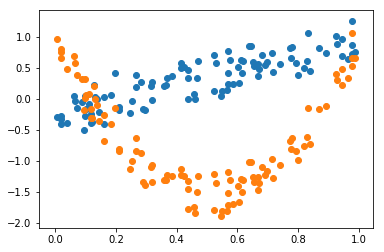

In [11]:
plt.scatter(X_lin_data, Y_lin_data)
plt.scatter(X_quad_data, Y_quad_data)

## Run

In [12]:
rng, rng_predict = random.split(random.PRNGKey(0))
samples = run_inference(model=model, data=quad_data, mcmc_params=[0, 500], rng=rng, dim_H=5)

/home/mathieu/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:114: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
sample: 100%|██████████| 300/300 [00:13<00:00, 22.21it/s, 1 steps of size 3.12e-02. acc. prob=0.32] 




                mean       std    median      5.0%     95.0%     n_eff     r_hat
   b1[0,0]     -0.98      0.20     -0.96     -0.99     -0.92     40.70      1.01
   b2[0,0]     -0.64      0.49     -0.78     -1.36      0.05      4.11      1.84
   w1[0,0]      5.29      1.28      5.56      5.14      6.03     16.94      1.10
   w2[0,0]     -2.42      0.30     -2.51     -2.68     -2.20     12.24      1.14




## Visualization

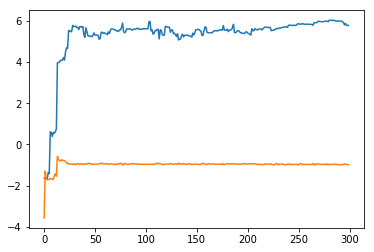

In [13]:
plot_samples_params(samples)

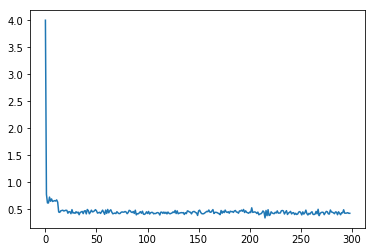

In [14]:
plot_loss(model, rng, samples, quad_data[0], 1, Y_quad_data)